In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import matplotlib.pyplot as plt
from scipy import stats, ndimage
import numpy as np
import glob
import czifile as zis
from skimage import img_as_float
from skimage.filters import threshold_li
import pandas as pd
from skimage import morphology

In [3]:
from skimage import exposure

In [4]:
import display

In [5]:
import os

In [6]:
import sys
sys.path.append(r'modules')

In [7]:
def array_czi(filename):
    # get CZI object and read array
    czi = zis.CziFile(filename)
    return np.squeeze(czi.asarray())

In [8]:
files = glob.glob("data/*.czi")

In [9]:
images = map(array_czi, files)

In [10]:
E34 = array_czi(files[2])
P638 = array_czi(files[1])
E273 = array_czi(files[0])

In [11]:
E34.shape

(2, 10, 580, 580)

In [12]:
E34_Ch1 = np.amax(E34[0,:,:,:], axis=0)
E34_Ch3 = exposure.equalize_adapthist(np.amax(E34[1,:,:,:], axis=0), clip_limit=0.015)
E34_toRGB = np.transpose(np.stack((E34_Ch1,E34_Ch3)), (1,2,0))
RGB_E34 = display.to_rgb(E34_toRGB, auto = False,bf = False,
                            Channel_0 = 'Cyan', Channel_1 = 'Magenta')

In [13]:
P638_Ch1 = np.amax(P638[0,:,:,:], axis=0)
P638_Ch3 = exposure.equalize_adapthist(np.amax(P638[1,:,:,:], axis=0), clip_limit=0.015)
P638_toRGB = np.transpose(np.stack((P638_Ch1,P638_Ch3)), (1,2,0))
RGB_P638 = display.to_rgb(P638_toRGB, auto = False,bf = False,
                            Channel_0 = 'Cyan', Channel_1 = 'Magenta')

In [14]:
E273_Ch1 = np.amax(E273[0,:,:,:], axis=0)
E273_Ch3 = exposure.equalize_adapthist(np.amax(E273[1,:,:,:], axis=0), clip_limit=0.015)
E273_toRGB = np.transpose(np.stack((E273_Ch1,E273_Ch3)), (1,2,0))
RGB_E273 = display.to_rgb(E273_toRGB, auto = False,bf = False,
                            Channel_0 = 'Cyan', Channel_1 = 'Magenta')

In [15]:
RGB_E34 = display.to_rgb(E34_toRGB, auto = False,bf = False,
                            Channel_0 = 'Cyan', Channel_1 = 'Magenta')

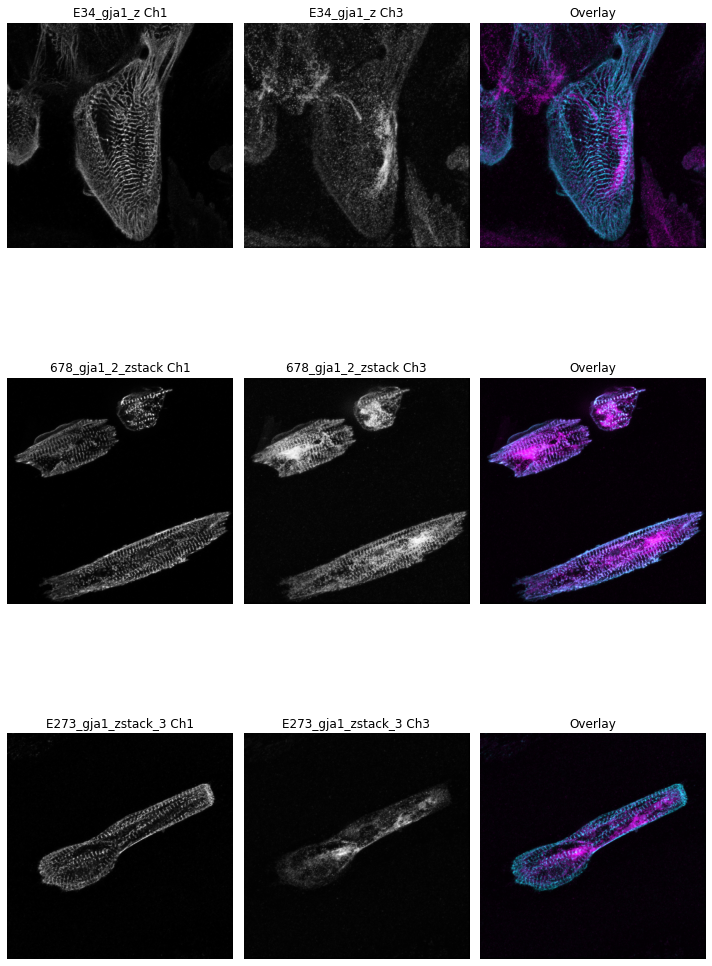

In [16]:
fig, axes = plt.subplots(3, 3, figsize=(10, 16))


axes[0,0].set_title('E34_gja1_z Ch1')
axes[0,0].imshow(np.amax(E34[0,:,:,:], axis=0), cmap=plt.cm.gray)
axes[0,0].set_axis_off()
axes[0,1].set_title('E34_gja1_z Ch3')
axes[0,1].imshow(exposure.equalize_adapthist(np.amax(E34[1,:,:,:], axis=0), clip_limit=0.015), cmap=plt.cm.gray)
axes[0,1].set_axis_off()
axes[0,2].imshow(RGB_E34)
axes[0,2].set_title('Overlay')
axes[0,2].set_axis_off()

axes[1,0].set_title('678_gja1_2_zstack Ch1')
axes[1,0].imshow(np.amax(P638[0,:,:,:], axis=0), cmap=plt.cm.gray)
axes[1,0].set_axis_off()
axes[1,1].set_title('678_gja1_2_zstack Ch3')
axes[1,1].imshow(exposure.equalize_adapthist(np.amax(P638[1,:,:,:], axis=0), clip_limit=0.015), cmap=plt.cm.gray)
axes[1,1].set_axis_off()
axes[1,2].imshow(RGB_P638)
axes[1,2].set_title('Overlay')
axes[1,2].set_axis_off()

axes[2,0].set_title('E273_gja1_zstack_3 Ch1')
axes[2,0].imshow(np.amax(E273[0,:,:,:], axis=0), cmap=plt.cm.gray)
axes[2,0].set_axis_off()
axes[2,1].set_title('E273_gja1_zstack_3 Ch3')
axes[2,1].imshow(exposure.equalize_adapthist(np.amax(E273[1,:,:,:], axis=0), clip_limit=0.010), cmap=plt.cm.gray)
axes[2,1].set_axis_off()
axes[2,2].imshow(RGB_E273)
axes[2,2].set_title('Overlay')
axes[2,2].set_axis_off()

fig.tight_layout()

In [17]:
_, filenames = zip(*[os.path.split(file) for file in files])

E273_ACTN1_9_z.czi started
678_ACTN1_10_z.czi started
E34_ACTN1_4_z.czi started


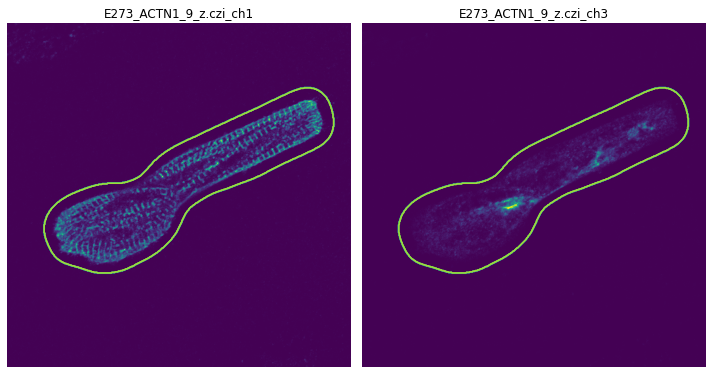

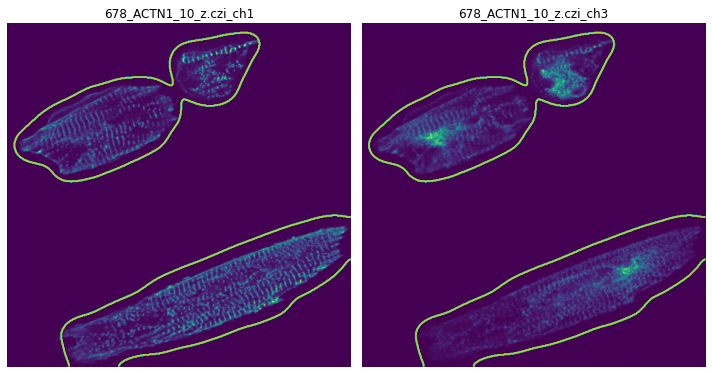

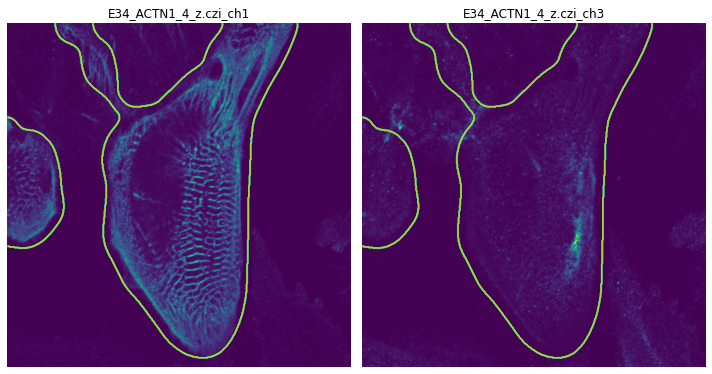

In [18]:
result = {}

for file, filename in zip(files, filenames):
    print(f'{filename} started')
    im = array_czi(file)
    dim = im.shape
        
    img = img_as_float(im)
    pos = np.argmax([np.mean(im) for im in img[0,:,:,:]])
    
    img_ch1 = img[0,pos,:,:]
    if dim[0] == 3:
        img_ch3 = img[2,pos,:,:]
    else:
        img_ch3 = img[1,pos,:,:]
        
    img_for_mask = ndimage.gaussian_filter(img_ch1, sigma=15)
    
    thr_ch3 = threshold_li(img_for_mask)
    binary_mask = img_for_mask>thr_ch3
    binary_mask_cl = morphology.remove_small_objects(binary_mask, 10000)
    binary_mask_cl = morphology.remove_small_holes(binary_mask_cl, 10000)
    
    msk_indices = np.nonzero(binary_mask_cl)

    
    A_plot = img_ch1[msk_indices[0],msk_indices[1]]
    B_plot = img_ch3[msk_indices[0],msk_indices[1]]
    
    _, _, r_value, _, _ = stats.linregress(A_plot,B_plot)
    s_value, _ = stats.spearmanr(A_plot,B_plot)
    result[filename[:-4]] = {'Pearson':r_value, 'Spearman':s_value}
    
    fig, ax = plt.subplots(1,2, figsize=(10,10))
    ax[0].imshow(img_ch1)
    ax[0].contour(binary_mask_cl)
    ax[0].set_axis_off()
    ax[0].set_title(filename + '_ch1')
    ax[1].imshow(img_ch3)
    ax[1].contour(binary_mask_cl)
    ax[1].set_axis_off()
    ax[1].set_title(filename + '_ch3')
    fig.tight_layout()


In [19]:
data = pd.DataFrame.from_dict(result, orient='index')

In [20]:
data

,Pearson,Spearman
E273_ACTN1_9_z,0.143070,0.640524
678_ACTN1_10_z,0.506722,0.798780
E34_ACTN1_4_z,0.212817,0.445332


In [21]:
df1 = data[data.index.str.startswith('E34')]

In [22]:
df2 = data[data.index.str.startswith('678')]

In [23]:
df3 = data[data.index.str.startswith('E273')]

In [24]:
data['experience'] = np.nan

In [25]:
data['experience'][data['Pearson'].isin(df1['Pearson'])] = 'E34'
data['experience'][data['Pearson'].isin(df2['Pearson'])] = '678'
data['experience'][data['Pearson'].isin(df3['Pearson'])] = 'E273'

In [26]:
import seaborn as sns

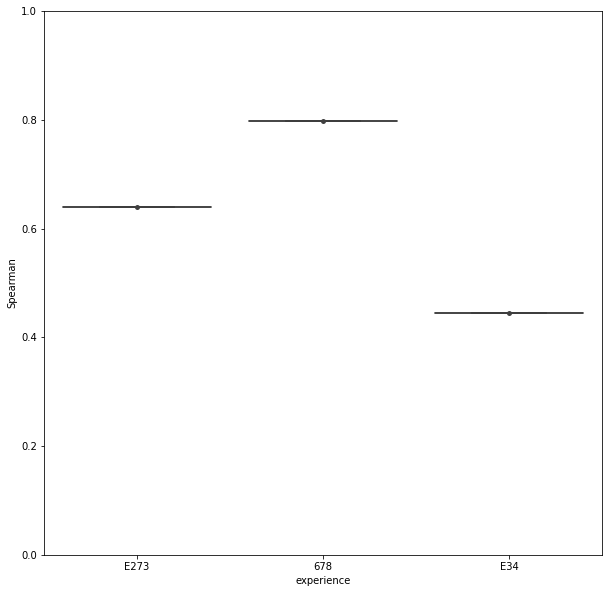

In [27]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax = sns.boxplot(x="experience", y="Spearman", data=data)
ax = sns.swarmplot(x="experience", y="Spearman", data=data, color=".25")
ax.set(ylim=(0, 1));